## HRRR Downscale Investigation

snowtools/isnoda/comparison/HRRR/

#### Single day comparison for IRWIN Snotel

##### Matt Olson - 11/02/2024

In [1]:
# load packages
from snobedo.shortwave import TopoShade
from snobedo.input import SmrfTopo
from snobedo.snotel import SnotelLocations

import numpy as np
from pathlib import Path, PurePath
from datetime import datetime
import random

from osgeo import gdal, osr

import matplotlib.pyplot as plt

# topo shade for a day.py

#### Read in paths and files

In [2]:
# paths
SHARED_STORE = PurePath('/uufs/chpc.utah.edu/common/home/skiles-group1')
DATA_DIR = SHARED_STORE.joinpath('jmeyer')
SNOTEL_DIR = DATA_DIR.joinpath( 'Snotel')
year = 2022
water_year = f'wy{year}'

In [3]:
# read in snotel point data
# focus on IRWIN
snotel_sites = SnotelLocations()
snotel_sites.load_from_json(SNOTEL_DIR / 'site-locations/snotel_sites.json')
snotel_sites.Irwin

SnotelSite(name='Irwin', lon=[317131], lat=[4306375])

In [4]:
# read in DEM
# d = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmeyer/project-data/iSnobal/ERW/topo/basin_setup/topo.nc"
d = "/uufs/chpc.utah.edu/common/home/u1037042/Documents/isnobal_data/toponc_ERW/topo.nc"
topo = gdal.Open(d, gdal.GA_ReadOnly)
topo
topo1 = gdal.Open(topo.GetSubDatasets()[0][0])
spatial_info = osr.SpatialReference()
spatial_info.SetFromUserInput(topo1.GetProjection())
print(spatial_info)

PROJCS["WGS84/UTMzone13N",
    GEOGCS["WGS84",
        DATUM["WGS_1984",
            SPHEROID["WGS84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-105],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32613"]]


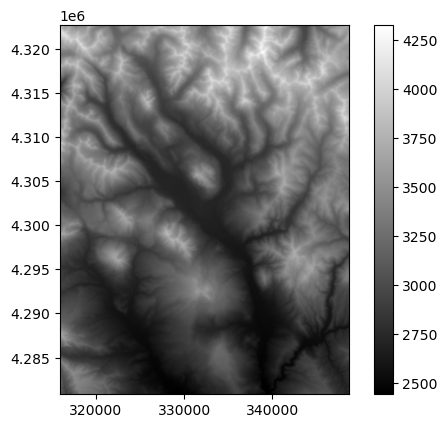

In [5]:
# plot DEM
# Read the data from the first band
band = topo1.GetRasterBand(1)
data = band.ReadAsArray()

# Get the geotransform information
geotransform = topo1.GetGeoTransform()

# Plot the data
plt.imshow(data, cmap='gray', extent=[geotransform[0], geotransform[0] + geotransform[1] * topo1.RasterXSize,
                                      geotransform[3] + geotransform[5] * topo1.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [6]:
## HELPER FUNCTIONS
# extract extent of data
def gdal_output_bounds(topo):
        geo_transform = topo.GetGeoTransform()
        return [
            geo_transform[0],
            geo_transform[3] + geo_transform[5] * topo.RasterYSize,
            geo_transform[0] + geo_transform[1] * topo.RasterXSize,
            geo_transform[3]
        ]

In [7]:
# for topocalc
def time_range_for(start, end):
    time_range = np.arange(
        start,
        end,
        np.timedelta64(1, 'h'),
        dtype='datetime64[s]'
    )
    return [datetime.fromisoformat(str(r)) for r in time_range]

#### Original Method

In [8]:
# 2. CALCULATE Illumination of slope
# run topo calc for day
# grab corresponding hour
# produce illumination intensity
# simple numpy HRRR * intensity
# FOR Illumination - COS of incidence angle?

# generate skyview
topo_shade = TopoShade(
        "/uufs/chpc.utah.edu/common/home/u1037042/Documents/isnobal_data/toponc_ERW/topo.nc", # saved copy of topo.nc
    "skyfield" 
    )

start_day = "2022-04-01"
end_day = "2022-04-02"

# calculate illumination angle for a day
topo_shade.calculate(
        time_range_for(start_day, end_day) # day 1 and next day
    )

In [9]:
type(topo_shade.illumination_angles)

dict

In [10]:
list(topo_shade.illumination_angles)[12]

datetime.datetime(2022, 4, 1, 18, 0, tzinfo=<UTC>)

In [11]:
topo_shade.zenith[list(topo_shade.zenith)[12]]
topo_shade.zenith.values()

dict_values([0, 0, 0, 0, 0, 0, 0, 83.48762140706798, 71.83976207918754, 60.51679456806828, 50.013801940995954, 41.172089124648096, 35.40565165122356, 34.373812239660616, 38.46847215372501, 46.313308420793895, 56.29157312516404, 67.3576622748535, 78.91003475334918, 87.6560287675178, 0, 0, 0, 0])

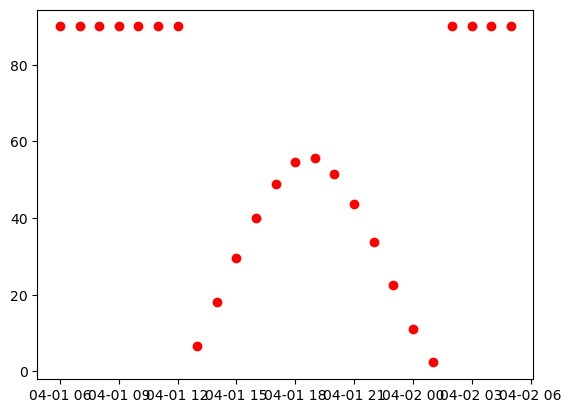

In [12]:
# plot zenith (solar elevation)
solar_elv = [90 - x for x in topo_shade.zenith.values()]
plt.figure()
plt.scatter(topo_shade.zenith.keys(), solar_elv, color='red')
plt.show()

In [13]:
# from snobedo.shortwave import add_illumination_angle 

# can access illumination _angle file - seems like self-shading

In [14]:
geotransform = topo1.GetGeoTransform()
x_resolution = geotransform[1]
y_resolution = geotransform[5]
print( x_resolution + y_resolution)
topo1.RasterXSize
float(x_resolution)

0.0


50.0

In [15]:
# convert elevation to type for tpocalc
dem = topo1.GetRasterBand(1).ReadAsArray()
dem2 = dem.astype(np.double)
dem2

array([[3576.69824219, 3589.36132812, 3599.52539062, ..., 3706.17773438,
        3714.56542969, 3718.16113281],
       [3606.23144531, 3619.91015625, 3635.71386719, ..., 3697.91894531,
        3706.26855469, 3710.46484375],
       [3642.26367188, 3665.57714844, 3695.79101562, ..., 3686.65136719,
        3695.55859375, 3700.64746094],
       ...,
       [3075.33984375, 3055.16503906, 3040.07226562, ..., 2723.90234375,
        2744.72949219, 2759.08886719],
       [3071.48632812, 3058.81152344, 3056.81640625, ..., 2713.35546875,
        2733.05371094, 2745.63085938],
       [3092.04492188, 3089.34179688, 3094.33105469, ..., 2700.45703125,
        2712.83105469, 2728.81835938]])

In [16]:
# generate sky view factor !!!
##
from topocalc.viewf import viewf

geotransform = topo1.GetGeoTransform()
x_resolution = geotransform[1]

sv = viewf(
    # "/uufs/chpc.utah.edu/common/home/u1037042/Documents/isnobal_data/toponc_ERW/topo.nc",
    dem2,
    float(x_resolution)
)
sv

(array([[0.9042536 , 0.89930318, 0.870132  , ..., 0.96911202, 0.97864659,
         0.98327573],
        [0.88182575, 0.86467179, 0.82023352, ..., 0.97555423, 0.98232606,
         0.98294166],
        [0.83151735, 0.81023649, 0.78060502, ..., 0.97026602, 0.97629762,
         0.97491128],
        ...,
        [0.87627426, 0.88630186, 0.87972826, ..., 0.95132577, 0.95479809,
         0.93753301],
        [0.90767528, 0.86609543, 0.844009  , ..., 0.95440486, 0.94864426,
         0.93143442],
        [0.89439054, 0.81855303, 0.78371487, ..., 0.96786409, 0.94660467,
         0.91806853]]),
 array([[0.01637132, 0.01532608, 0.02127114, ..., 0.01568003, 0.01144449,
         0.00966063],
        [0.02237884, 0.01528429, 0.02260024, ..., 0.00684009, 0.00527388,
         0.0078294 ],
        [0.0198031 , 0.01322287, 0.01878355, ..., 0.00848676, 0.00647577,
         0.01163834],
        ...,
        [0.0793454 , 0.08843194, 0.11071744, ..., 0.01429421, 0.01116522,
         0.0323677 ],
        [0.0

In [17]:
# sky view factor and
# terrain configuration factor (tvf) is defined as:
#     (1 + cos(slope))/2 - sky view factor

sv[0]

array([[0.9042536 , 0.89930318, 0.870132  , ..., 0.96911202, 0.97864659,
        0.98327573],
       [0.88182575, 0.86467179, 0.82023352, ..., 0.97555423, 0.98232606,
        0.98294166],
       [0.83151735, 0.81023649, 0.78060502, ..., 0.97026602, 0.97629762,
        0.97491128],
       ...,
       [0.87627426, 0.88630186, 0.87972826, ..., 0.95132577, 0.95479809,
        0.93753301],
       [0.90767528, 0.86609543, 0.844009  , ..., 0.95440486, 0.94864426,
        0.93143442],
       [0.89439054, 0.81855303, 0.78371487, ..., 0.96786409, 0.94660467,
        0.91806853]])

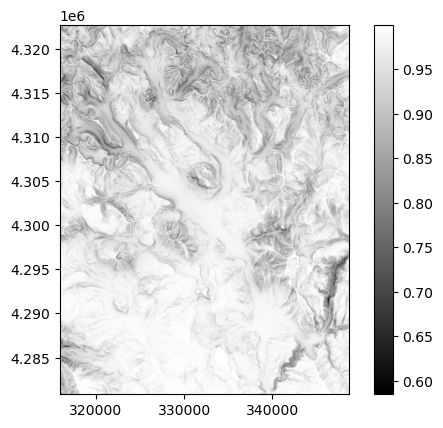

In [18]:
# plot sky view factor
geotransform = topo1.GetGeoTransform()

# Plot the data
plt.imshow(sv[0], cmap='gray', extent=[geotransform[0], geotransform[0] + geotransform[1] * topo1.RasterXSize,
                                      geotransform[3] + geotransform[5] * topo1.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

#### Apply illumination angles to HRRR over entire day

In [19]:
###  CONVERT HRRR to CRS of DEM
## Convert HRRR grib into numpy array (Gdal)
## warp HRRR to match topo.nc (for each - in a single day)

## 1. Read in HRRR xarray for single day
hrrr_img = '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t16z.wrfsfcf06.grib2'
hrrr_img = gdal.Open(hrrr_img)
hrrr_img

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f2d4830b570> >

In [20]:
# original dimensions
hrrr_img.GetRasterBand(10).ReadAsArray().shape

(314, 226)

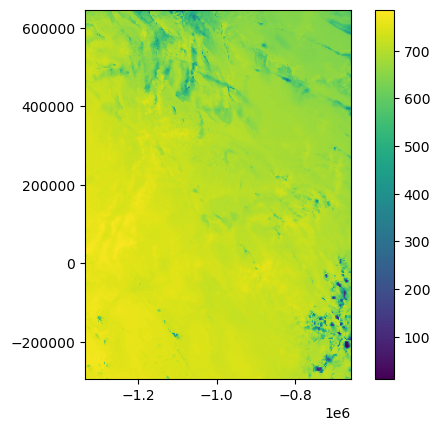

In [21]:
band_hrrr = hrrr_img.GetRasterBand(10) # 10th variable is sw
data_hrrr = band_hrrr.ReadAsArray()

# Get the geotransform information
geotransform = hrrr_img.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data_hrrr, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_img.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_img.RasterYSize, geotransform[3]])
plt.colorbar()
# plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

In [22]:
## 2. Reproject (warp)
# extract epsg code from dem
epsg_code = spatial_info.GetAuthorityName(None) + ":" + spatial_info.GetAuthorityCode(None)

# temp file
mem_hrrr_file = '/vsimem/grib_%i.tif' % random.getrandbits(32)

# warp options for topo files
options = gdal.WarpOptions(
            dstSRS=epsg_code,
            outputBoundsSRS=epsg_code,
            outputBounds= gdal_output_bounds(topo1),
            xRes=topo1.GetGeoTransform()[1],
            yRes=topo1.GetGeoTransform()[1],
            multithread=True,
        )

# warp file, original, options=topo1
gdal.Warp(mem_hrrr_file, hrrr_img, options=options)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f2cc478c900> >

In [23]:
## 3.5 reopen (save)
hrrr_warp = gdal.Open(mem_hrrr_file, gdal.GA_ReadOnly)
hrrr_warp

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f2cc47f03f0> >

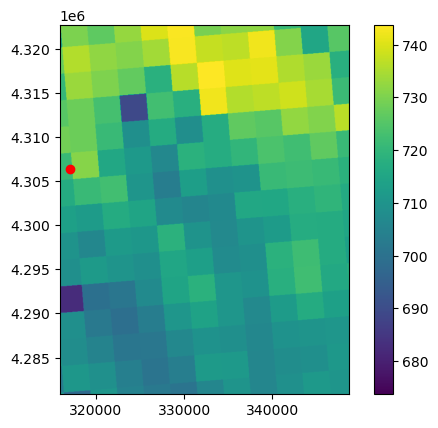

In [24]:
## 3.75 Plot
# Read the data from the first band
band_hrrr = hrrr_warp.GetRasterBand(10) # 10th variable is sw
data_hrrr = band_hrrr.ReadAsArray()

# Get the geotransform information
geotransform = hrrr_warp.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data_hrrr, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

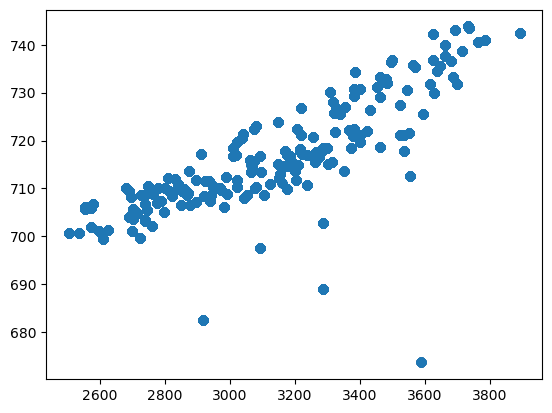

In [25]:
# sw vs elevation
# Read the data from the first band
band_hrrr = hrrr_warp.GetRasterBand(10) # 10th variable is sw
data_hrrr = band_hrrr.ReadAsArray()
band_elv = hrrr_warp.GetRasterBand(1) # 1st variable is gpt
data_elv = band_elv.ReadAsArray()

# Get the geotransform information
geotransform = hrrr_warp.GetGeoTransform()

# Plot the data
plt.figure()
plt.scatter(data_elv, data_hrrr)
plt.show()

In [26]:
data_hrrr

array([[712.60003662, 729.90002441, 729.90002441, ..., 725.5       ,
        725.5       , 725.5       ],
       [712.60003662, 729.90002441, 729.90002441, ..., 725.5       ,
        725.5       , 725.5       ],
       [712.60003662, 729.90002441, 729.90002441, ..., 725.5       ,
        725.5       , 725.5       ],
       ...,
       [711.20001221, 711.20001221, 711.20001221, ..., 710.20001221,
        710.20001221, 710.20001221],
       [711.20001221, 711.20001221, 711.20001221, ..., 710.20001221,
        710.20001221, 710.20001221],
       [711.20001221, 711.20001221, 711.20001221, ..., 710.20001221,
        710.20001221, 710.20001221]])

#### Combine illumination and HRRR SW

In [27]:
# check dimensions
data_hrrr.shape

(837, 656)

In [28]:
# test hour
# hrrr.t16z.wrfsfcf06.grib2
list(topo_shade.illumination_angles)[10]

datetime.datetime(2022, 4, 1, 16, 0, tzinfo=<UTC>)

In [29]:
# check dimensions
topo_illum16 = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[10]]
topo_illum16.shape

(837, 656)

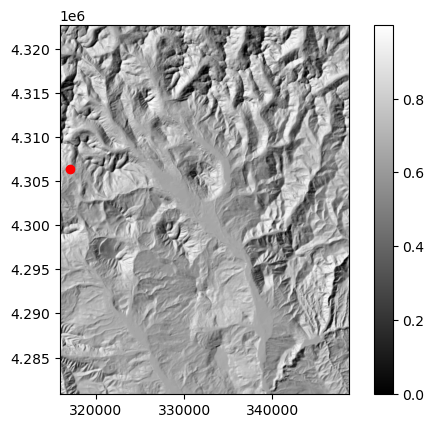

In [55]:
# plot illumination

# Get the geotransform information
geotransform = hrrr_warp.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(topo_illum16, cmap='grey', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

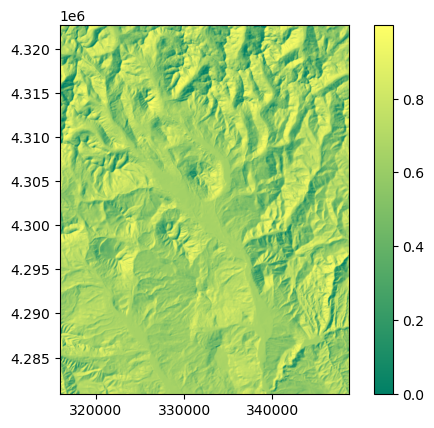

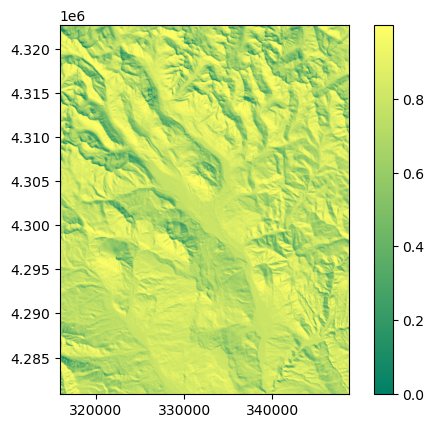

In [31]:
t_ill10  = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[14]]

# Plot the data
plt.figure()
plt.imshow(topo_illum16, cmap='summer', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

# Plot the data
plt.figure()
plt.imshow(t_ill10, cmap='summer', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [32]:
# distribute sw based on illumination angle
hrrr_sw_down = data_hrrr * topo_illum16

In [33]:
# needs projection
hrrr_sw_down

array([[141.11993805, 141.40623174, 104.73305421, ..., 414.90996172,
        449.69406705, 471.83220562],
       [ 96.58129066,  55.4980659 ,   0.        , ..., 419.02716966,
        451.08999505, 469.79706105],
       [  0.        ,   0.        ,   0.        , ..., 428.43162043,
        453.80654365, 467.90543075],
       ...,
       [640.34085669, 595.23867629, 512.17602342, ..., 309.20417561,
        318.92998971, 357.66980866],
       [497.757751  , 398.35841429, 294.98043018, ..., 357.03460692,
        362.82513972, 386.49960459],
       [333.65011363, 233.42268348, 194.82944092, ..., 439.21713937,
        391.15018898, 370.3524551 ]])

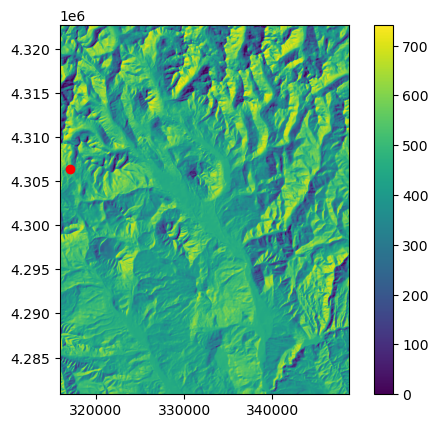

In [34]:
# Plot difference between scaled and downscaled
plt.figure()
plt.imshow(hrrr_sw_down, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

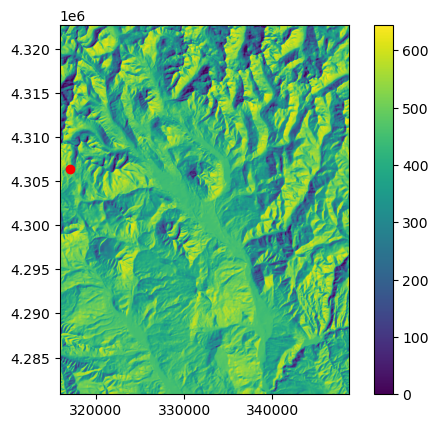

In [35]:
# add skyview
hrrr_sw_down_sky  = data_hrrr * topo_illum16 * sv[0]

# plot
plt.figure()
plt.imshow(hrrr_sw_down_sky, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()


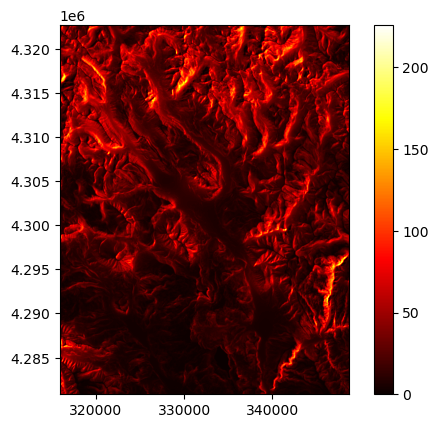

In [36]:
# plot differenced data
# hrrr_diff = data_hrrr - hrrr_sw_down
hrrr_diff = hrrr_sw_down - hrrr_sw_down_sky

plt.figure()
plt.imshow(hrrr_diff, cmap='hot', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
# plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

#### Check model output

In [37]:
# check that matches with output file!
# hrrr_img = '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t16z.wrfsfcf06.grib2'

hrrr_2022_base = '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc'

hrrr_smrf0 = gdal.Open(hrrr_2022_base, gdal.GA_ReadOnly)
hrrr_smrf = gdal.Open(hrrr_smrf0.GetSubDatasets()[5][0])

In [38]:
hrrr_smrf.GetMetadata()

{'NC_GLOBAL#CDI': 'Climate Data Interface version 2.0.5 (https://mpimet.mpg.de/cdi)',
 'NC_GLOBAL#CDO': 'Climate Data Operators version 2.0.5 (https://mpimet.mpg.de/cdo)',
 'NC_GLOBAL#Conventions': 'CF-1.6',
 'NC_GLOBAL#history': 'Mon Jul 25 15:46:09 2022: cdo -z zip4 -O splitday /uufs/chpc.utah.edu/common/home/u1135435/skiles-group1/SMESHR/net_HRRR/wy2022/net_HRRR.202204.nc /uufs/chpc.utah.edu/common/home/u1135435/skiles-group1/SMESHR/net_HRRR/wy2022/net_dswrf.MST.202204\nMon Jul 25 15:43:30 2022: cdo -z zip4 -O -aexpr,albedo=(0.67*albedo_vis)+(0.33*albedo_ir);net_solar=(1-albedo)*illumination_angle*DSWRF; /uufs/chpc.utah.edu/common/home/u1135435/skiles-group1/SMESHR/net_HRRR/wy2022/HRRR_SMRF.202204.nc /uufs/chpc.utah.edu/common/home/u1135435/skiles-group1/SMESHR/net_HRRR/wy2022/net_HRRR.202204.nc\nMon Jul 25 15:41:45 2022: cdo -z zip4 -O merge -selmonth,04 /uufs/chpc.utah.edu/common/home/u1135435/skiles-group1/SMESHR/net_HRRR/wy2022/dswrf.202204.nc -selmonth,04 /uufs/chpc.utah.edu/co

In [39]:
hrrr_smrf0.GetSubDatasets()
# the 5th one!

[('NETCDF:"/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc":DSWRF',
  '[24x837x656] DSWRF (64-bit floating-point)'),
 ('NETCDF:"/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc":illumination_angle',
  '[24x837x656] illumination_angle (32-bit floating-point)'),
 ('NETCDF:"/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc":albedo_ir',
  '[24x837x656] albedo_ir (32-bit floating-point)'),
 ('NETCDF:"/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc":albedo_vis',
  '[24x837x656] albedo_vis (32-bit floating-point)'),
 ('NETCDF:"/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc":albedo',
  '[24x837x656] albedo (32-bit floating-point)'),
 ('NETCDF:"/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr

In [40]:
hrrr_smrf.GetMetadata().get('NETCDF_DIM_EXTRA')

'{time}'

In [41]:
# 24 hours?
hrrr_smrf.RasterCount

24

In [42]:
hrrr_smrf.GetRasterBand(24).GetMetadata()

{'grid_mapping': 'projection',
 'missing_value': '-8.9999999e+33',
 'NETCDF_DIM_time': '41',
 'NETCDF_VARNAME': 'net_solar',
 '_FillValue': '-8.9999999e+33'}

In [43]:
# dimensions - downscaled should be (837, 656)
hrrr_smrf.GetRasterBand(16).ReadAsArray().shape

(837, 656)

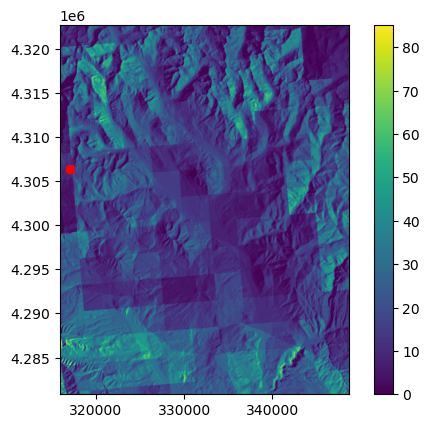

In [44]:
# Read the data from the first band
band = hrrr_smrf.GetRasterBand(16)
data_smrf = band.ReadAsArray()

# Get the geotransform information
geotransform = hrrr_smrf.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data_smrf, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_smrf.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_smrf.RasterYSize, geotransform[3]])
plt.colorbar()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

In [45]:
## BLANK DATA - not same date or dimension

# LOOKS VERY DIFFERENT

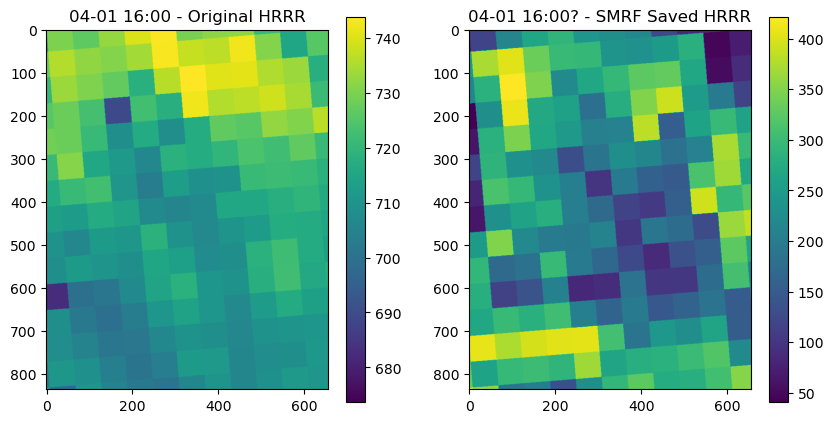

In [72]:
# COMPARE
# compare current scene with saved

### ORIGINAL DATA (from top)
# '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t16z.wrfsfcf06.grib2'
# 10th variable - at 1600
# hrrr_image is April 1st at 16:00 (9AM)
# use warped image
band_hrrr = hrrr_warp.GetRasterBand(10) # 10th variable is sw
data_hrrr = band_hrrr.ReadAsArray()

# SMRF OUTPUT DATA
# '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc'
# 0 variable at 16 hr?
#
# hrrr_2022_base = '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc'
# hrrr_smrf0 = gdal.Open(hrrr_2022_base, gdal.GA_ReadOnly)
hrrr_smrf_00 = gdal.Open(hrrr_smrf0.GetSubDatasets()[0][0]) # DWSF
band16hr = hrrr_smrf_00.GetRasterBand(16)
data_smrf_16hr = band16hr.ReadAsArray()


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(data_hrrr, cmap='viridis')
axs[0].set_title('04-01 16:00 - Original HRRR')

im2 = axs[1].imshow(data_smrf_16hr, cmap='viridis')
axs[1].set_title('04-01 16:00? - SMRF Saved HRRR')

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

In [47]:
# time is not lining up???
import xarray as xr

hrrr_smrf_xr = xr.open_mfdataset('/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc')
hrrr_smrf_xr.DSWRF

<xarray.DataArray 'DSWRF' (time: 24, y: 837, x: 656)> Size: 105MB
dask.array<open_dataset-DSWRF, shape=(24, 837, 656), dtype=float64, chunksize=(1, 837, 656), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 192B 2022-04-01 ... 2022-04-01T23:00:00
  * x        (x) float32 3kB 3.159e+05 3.16e+05 3.16e+05 ... 3.486e+05 3.487e+05
  * y        (y) float32 3kB 4.323e+06 4.323e+06 ... 4.281e+06 4.281e+06
Attributes:
    long_name:     HRRR - DSWRF
    units:         [W/(m^2)]
    grid_mapping:  projection
    description:   Downward short-wave radiation flux [W/(m^2)]

In [48]:
print(len(hrrr_smrf_xr.time))
hrrr_smrf_xr.time[16]

24


<xarray.DataArray 'time' ()> Size: 8B
array('2022-04-01T16:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-04-01T16:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

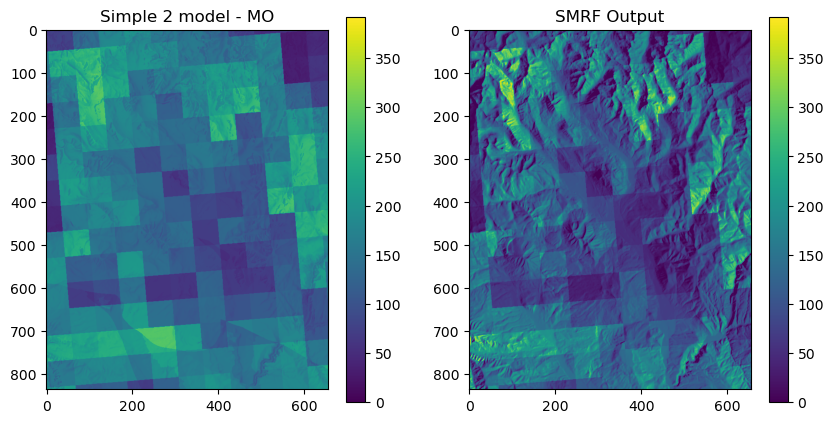

In [87]:
# SMRF OUTPUT DATA
# '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc'
# at 16 hr

# open connection to file
hrrr_2022_base = '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run20220401/net_solar.nc'
hrrr_smrf0 = gdal.Open(hrrr_2022_base, gdal.GA_ReadOnly)

time_step = 16
#
# GET ORIGINAL HRRR
hrrr_smrf_00 = gdal.Open(hrrr_smrf0.GetSubDatasets()[0][0]) # DWSF
band_shr = hrrr_smrf_00.GetRasterBand(time_step)
data_smrf_hrrr = band_shr.ReadAsArray()

# GET Illumination
hrrr_smrf_20 = gdal.Open(hrrr_smrf0.GetSubDatasets()[2][0]) # Illum
band_ill = hrrr_smrf_20.GetRasterBand(time_step)
data_smrf_ill = band_ill.ReadAsArray()

# # # # # # # # # # # 
# SIMPLE Calculation ( what is missing? - clouds, veg, etc. )
swmod_down = data_smrf_hrrr * data_smrf_ill * sv[0]
# swmod_down = data_smrf_hrrr * data_smrf_ill

# GET SMRF OUT
hrrr_smrf_50 = gdal.Open(hrrr_smrf0.GetSubDatasets()[5][0]) # SMRF
band_smrf = hrrr_smrf_50.GetRasterBand(time_step)
data_smrf_mod = band_smrf.ReadAsArray()

# backout albedo
hrrr_smrf_40 = gdal.Open(hrrr_smrf0.GetSubDatasets()[4][0]) # Albedo
band_alb = hrrr_smrf_40.GetRasterBand(time_step)
data_smrf_alb = band_alb.ReadAsArray()

# joe's calculation
sw_in_smrf = data_smrf_mod / (1 - data_smrf_alb)

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(swmod_down.min(), sw_in_smrf.min())
vmax = max(swmod_down.max(), sw_in_smrf.max())

# PLOTS
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(swmod_down, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Simple 2 model - MO')

im2 = axs[1].imshow(sw_in_smrf, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('SMRF Output')

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

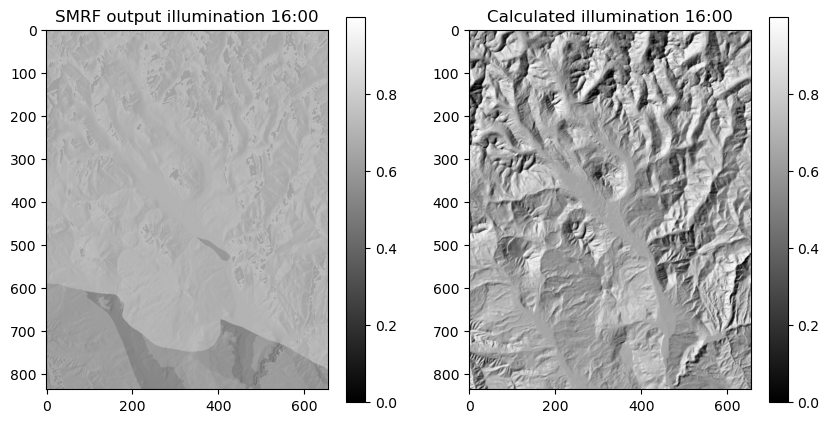

In [66]:

# # Plot the data
# plt.figure()
# plt.imshow(data_smrf_ill, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_smrf.RasterXSize,
#                                       geotransform[3] + geotransform[5] * hrrr_smrf.RasterYSize, geotransform[3]])
# plt.colorbar()
# plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
# plt.show()

# OTHER Illumination @ 16:00
topo_illum_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[10]]

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(data_smrf_ill.min(), topo_illum_hr.min())
vmax = max(data_smrf_ill.max(), topo_illum_hr.max())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(data_smrf_ill, cmap='grey', vmin=vmin, vmax=vmax)
axs[0].set_title('SMRF output illumination 16:00')

im2 = axs[1].imshow(topo_illum_hr, cmap='grey', vmin=vmin, vmax=vmax))
axs[1].set_title('Calculated illumination 16:00')

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

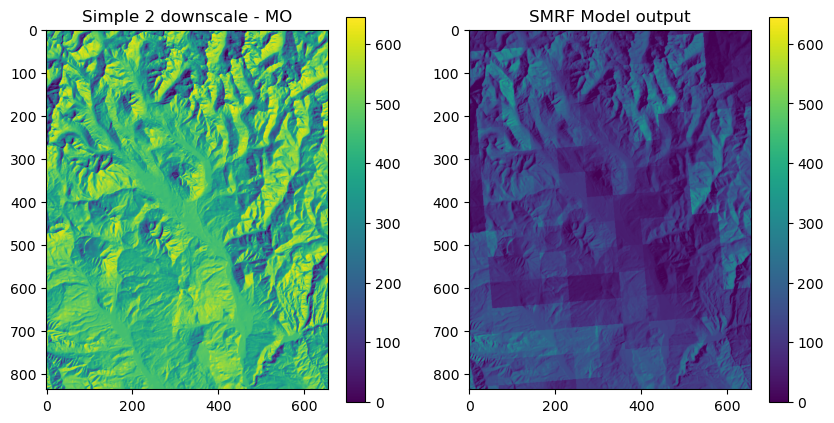

In [93]:
# Better match with 1800?

time_step = 16

# GET SMRF OUT
hrrr_smrf_50 = gdal.Open(hrrr_smrf0.GetSubDatasets()[5][0]) # SMRF
band_smrf = hrrr_smrf_50.GetRasterBand(time_step)
data_smrf_mod = band_smrf.ReadAsArray()

# backout albedo
hrrr_smrf_40 = gdal.Open(hrrr_smrf0.GetSubDatasets()[4][0]) # Albedo
band_alb = hrrr_smrf_40.GetRasterBand(time_step)
data_smrf_alb = band_alb.ReadAsArray()

# joe's calculation
sw_in_smrf = data_smrf_mod / (1 - data_smrf_alb)

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(hrrr_sw_down_sky.min(), sw_in_smrf.min())
vmax = max(hrrr_sw_down_sky.max(), sw_in_smrf.max())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(hrrr_sw_down_sky, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Simple 2 downscale - MO')

im2 = axs[1].imshow(sw_in_smrf, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('SMRF Model output')

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

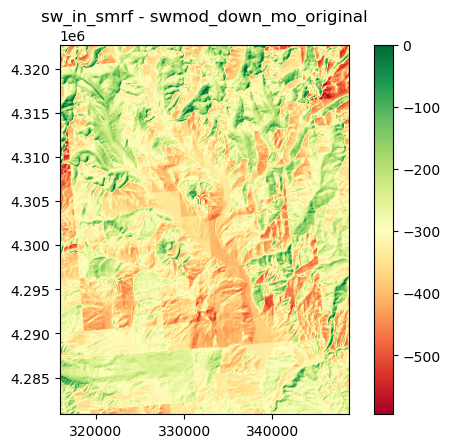

In [94]:
hrrr_diff2 = sw_in_smrf - hrrr_sw_down_sky
# more positive values are higher at 18:00 SMRF

plt.figure()
plt.imshow(hrrr_diff2, cmap='RdYlGn', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.title('sw_in_smrf - swmod_down_mo_original')
plt.colorbar()
# plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

In [ ]:
# seems like aspect dependence and grid patterns
# they are different time periods

In [106]:
# verify that is 16:00 UTC
list(topo_shade.illumination_angles)[14]

datetime.datetime(2022, 4, 1, 20, 0, tzinfo=<UTC>)

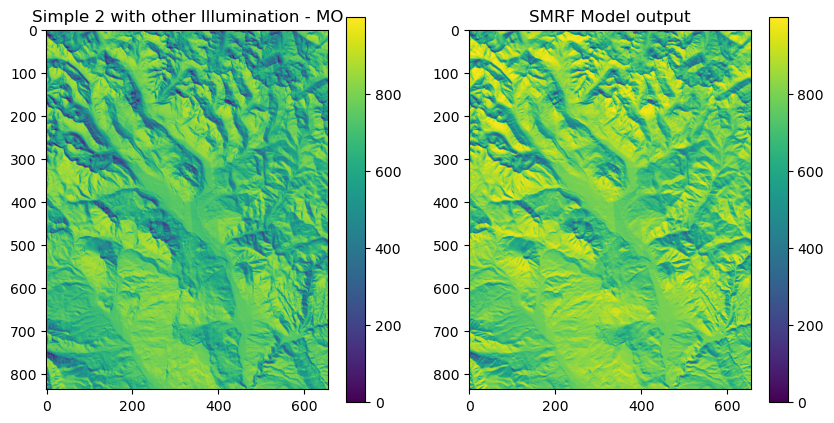

In [109]:
# USE original Illumination layer for saved DWSR

time_step = 20

# GET ORIGINAL HRRR
hrrr_smrf_00 = gdal.Open(hrrr_smrf0.GetSubDatasets()[0][0]) # DWSF
band_shr = hrrr_smrf_00.GetRasterBand(time_step)
data_smrf_hrrr = band_shr.ReadAsArray()

# OTHER Illumination 
match_illum = time_step - 6
topo_illum_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[match_illum]] # 10 for 1600 / 14 for 2000

# SIMPLE Calculation 
swmod_down = data_smrf_hrrr * topo_illum_hr * sv[0]

# GET SMRF OUT
hrrr_smrf_50 = gdal.Open(hrrr_smrf0.GetSubDatasets()[5][0]) # SMRF
band_smrf = hrrr_smrf_50.GetRasterBand(time_step)
data_smrf_mod = band_smrf.ReadAsArray()

# backout albedo
hrrr_smrf_40 = gdal.Open(hrrr_smrf0.GetSubDatasets()[4][0]) # Albedo
band_alb = hrrr_smrf_40.GetRasterBand(time_step)
data_smrf_alb = band_alb.ReadAsArray()

# joe's calculation
sw_in_smrf = data_smrf_mod / (1 - data_smrf_alb)

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(swmod_down.min(), sw_in_smrf.min())
vmax = max(swmod_down.max(), sw_in_smrf.max())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(swmod_down, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Simple 2 with other Illumination - MO')

im2 = axs[1].imshow(sw_in_smrf, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('SMRF Model output')

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

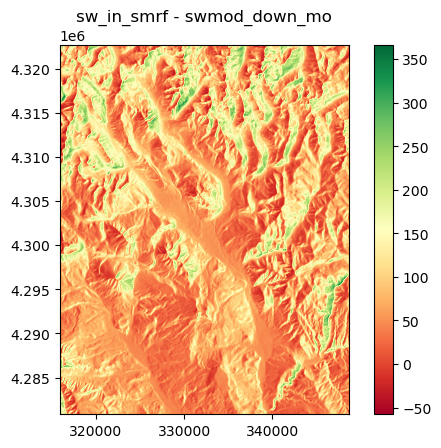

In [110]:
hrrr_diff2 = sw_in_smrf - swmod_down
# more positive values are higher at 18:00 SMRF

plt.figure()
plt.imshow(hrrr_diff2, cmap='RdYlGn', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.title('sw_in_smrf - swmod_down_mo')
plt.colorbar()

# plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

In [ ]:
## GOOD - this is what we should be seeing!
# 1600 not too bad of bias
# 2000 (1pm) much worse

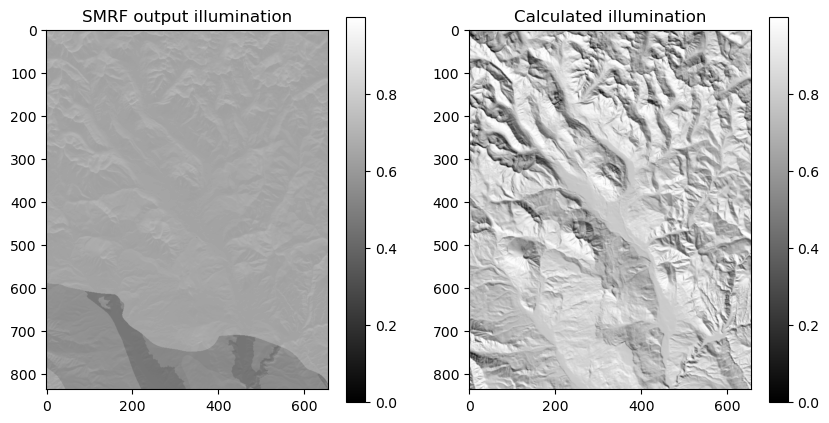

In [115]:

time_step = 20

# OTHER Illumination 
match_illum = time_step - 6
topo_illum_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[match_illum]] # 10 for 1600 / 14 for 2000

# GET HRRR Illumination
hrrr_smrf_20 = gdal.Open(hrrr_smrf0.GetSubDatasets()[2][0]) # Illum
band_ill = hrrr_smrf_20.GetRasterBand(time_step)
data_smrf_ill = band_ill.ReadAsArray()

# PLOT

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(data_smrf_ill.min(), topo_illum_hr.min())
vmax = max(data_smrf_ill.max(), topo_illum_hr.max())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(data_smrf_ill, cmap='grey', vmin=vmin, vmax=vmax)
axs[0].set_title('SMRF output illumination')

im2 = axs[1].imshow(topo_illum_hr, cmap='grey', vmin=vmin, vmax=vmax)
axs[1].set_title('Calculated illumination')

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

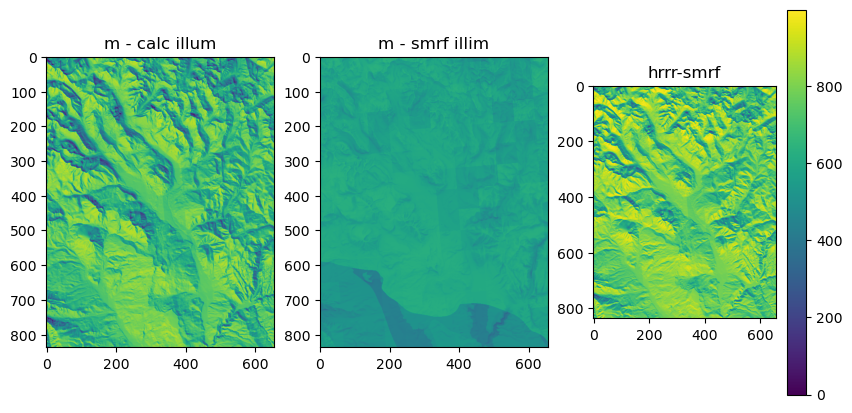

In [117]:
# SHOW ALL

month_day = '0401'

# open connection to file
hrrr_2022_base = '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run2022' + month_day + '/net_solar.nc'
hrrr_smrf0 = gdal.Open(hrrr_2022_base, gdal.GA_ReadOnly)

time_step = 20

# GET ORIGINAL HRRR
hrrr_smrf_00 = gdal.Open(hrrr_smrf0.GetSubDatasets()[0][0]) # DWSF
band_shr = hrrr_smrf_00.GetRasterBand(time_step)
data_smrf_hrrr = band_shr.ReadAsArray()

# GET Illumination
hrrr_smrf_20 = gdal.Open(hrrr_smrf0.GetSubDatasets()[2][0]) # Illum
band_ill = hrrr_smrf_20.GetRasterBand(time_step)
data_smrf_ill = band_ill.ReadAsArray()

# OTHER Illumination 
match_illum = time_step - 6
topo_illum_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[match_illum]] # 10 for 1600 / 14 for 2000

# # # # # # # # # # #
# SIMPLE Calculation 
swmod_down_i = data_smrf_hrrr * topo_illum_hr * sv[0]
swmod_down_sm = data_smrf_hrrr * data_smrf_ill * sv[0]

# GET SMRF OUT
hrrr_smrf_50 = gdal.Open(hrrr_smrf0.GetSubDatasets()[5][0]) # SMRF
band_smrf = hrrr_smrf_50.GetRasterBand(time_step)
data_smrf_mod = band_smrf.ReadAsArray()

# backout albedo
hrrr_smrf_40 = gdal.Open(hrrr_smrf0.GetSubDatasets()[4][0]) # Albedo
band_alb = hrrr_smrf_40.GetRasterBand(time_step)
data_smrf_alb = band_alb.ReadAsArray()

# joe's calculation
sw_in_smrf = data_smrf_mod / (1 - data_smrf_alb)

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(swmod_down.min(), sw_in_smrf.min())
vmax = max(swmod_down.max(), sw_in_smrf.max())

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(swmod_down_i, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('m - calc illum')

im1 = axs[1].imshow(swmod_down_sm, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('m - smrf illim')

im2 = axs[2].imshow(sw_in_smrf, cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].set_title('hrrr-smrf')

# Add colorbars
# fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
# fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot
fig.colorbar(im2, ax=axs[2])  # Colorbar for the second subplot

plt.show()

## Joe Hypothesis

##### HRRR bias exists due to using the mean grid cell elevation to model downward shortwave. 

##### This value will be significant unless for fully cloud covered days

#### Method 1

- On a clear HRRR day - cloud cover = 0%
- Use the HRRR grid cell containing Irwin
- Retrieve the max and min elevation based on the model topo file
    + Check how much lower/higher Irwin is from the mean grid value
    + HRRR has elevation data in the surface HGT field (#139, name: orog)
- Model the theoretically clear sky radiation for all topo grid cells within the single HRRR grid cell
    + Show the variation of possible incoming shortwave
- Look for model (topo) grid cells that fall within the HRRR mean elevation and compare to the HRRR value
    + Check the difference of the mean value to the value of the cell with Irwin
- Derive shortwave scaling factors based on the value with the mean elevation
- Apply the scaling factors to the HRRR value
    + Compare the Irwin pixel again with the new scaled HRRR value


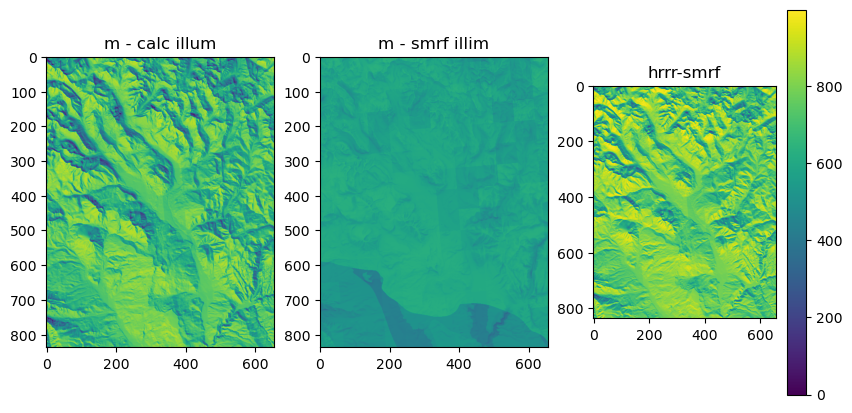

In [118]:
# find clear sky moment

month_day = '0401'

# open connection to file
hrrr_2022_base = '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/run2022' + month_day + '/net_solar.nc'
hrrr_smrf0 = gdal.Open(hrrr_2022_base, gdal.GA_ReadOnly)

time_step = 20

# GET ORIGINAL HRRR
hrrr_smrf_00 = gdal.Open(hrrr_smrf0.GetSubDatasets()[0][0]) # DWSF
band_shr = hrrr_smrf_00.GetRasterBand(time_step)
data_smrf_hrrr = band_shr.ReadAsArray()

# GET Illumination
hrrr_smrf_20 = gdal.Open(hrrr_smrf0.GetSubDatasets()[2][0]) # Illum
band_ill = hrrr_smrf_20.GetRasterBand(time_step)
data_smrf_ill = band_ill.ReadAsArray()

# OTHER Illumination 
match_illum = time_step - 6
topo_illum_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[match_illum]] # 10 for 1600 / 14 for 2000

# # # # # # # # # # #
# SIMPLE Calculation 
swmod_down_i = data_smrf_hrrr * topo_illum_hr * sv[0]
swmod_down_sm = data_smrf_hrrr * data_smrf_ill * sv[0]

# GET SMRF OUT
hrrr_smrf_50 = gdal.Open(hrrr_smrf0.GetSubDatasets()[5][0]) # SMRF
band_smrf = hrrr_smrf_50.GetRasterBand(time_step)
data_smrf_mod = band_smrf.ReadAsArray()

# backout albedo
hrrr_smrf_40 = gdal.Open(hrrr_smrf0.GetSubDatasets()[4][0]) # Albedo
band_alb = hrrr_smrf_40.GetRasterBand(time_step)
data_smrf_alb = band_alb.ReadAsArray()

# joe's calculation
sw_in_smrf = data_smrf_mod / (1 - data_smrf_alb)

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(swmod_down.min(), sw_in_smrf.min())
vmax = max(swmod_down.max(), sw_in_smrf.max())

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(swmod_down_i, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('m - calc illum')

im1 = axs[1].imshow(swmod_down_sm, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('m - smrf illim')

im2 = axs[2].imshow(sw_in_smrf, cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].set_title('hrrr-smrf')

# Add colorbars
# fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
# fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot
fig.colorbar(im2, ax=axs[2])  # Colorbar for the second subplot

plt.show()

In [ ]:
# extract elevation for Irwin
# need to find time descrepancy with original HRR data to extract HGT layer

In [ ]:
# model Irwin comparison

In [ ]:
# Irwin SW values for day

#### Cloud cover comparison

In [ ]:
# joe email

#### Smoothing comparison

In [ ]:
# Brent wilder - added self shading?
# COULD ADD new self shading - update topocalc
# look into 